In [110]:
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Flatten
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical



In [111]:
if tf.config.list_physical_devices('GPU'):
    print("GPU mevcut.")
else:
    print("GPU mevcut değil.")


GPU mevcut.


In [112]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [113]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

# **Veri Ön işleme**

## Veri Yükleme ve DataFrame Oluşturma

Bu adımda, veri setimizdeki `.png` formatındaki balık resimlerini okuyarak bir **Pandas DataFrame** oluşturuyoruz. Bu işlem, verilerin modelde kullanılmadan önce uygun bir formatta düzenlenmesini sağlar. Her bir resmin dosya yolu ve ait olduğu etiket (label), bu DataFrame'e eklenir.

- `os.walk()` kullanılarak belirtilen dizindeki tüm alt klasörlerde gezinilir.
- `.png` dosya uzantısına sahip resimler filtrelenir.
- **Resmin etiketi**: Dosya yolunun klasör adından elde edilir. Her resim, hangi balık türüne ait olduğunu belirtmek için klasör adı ile etiketlenir.
- **Resmin yolu**: Her resmin tam dosya yolu kaydedilir.
- **Pandas DataFrame**: Bu yollar ve etiketler, iki sütunlu bir DataFrame olarak organize edilir. Sütunlar `path` ve `label` olarak adlandırılır.

Bu adımın sonunda, modelde kullanılmak üzere hazırlanmış bir veri seti oluşturmuş oluruz.


In [114]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'


for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  
            if dir_name.split()[-1] != 'GT': 
                label.append(os.path.split(dir_name)[-1])  
                path.append(os.path.join(dir_name, filename)) 
                
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label


## Veri Analizi

- **İlk 5 satırı görüntüleme:**

In [115]:
data.head() 

path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel

- **Son 5 satırı görüntüleme:**

In [116]:
data.tail() 

path          label
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Red Sea Bream

 - **Etiketlerin benzersiz değerlerini gösterme:** 

In [117]:
data['label'].unique()

array(['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
       'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream',
       'Red Sea Bream'], dtype=object)

- **Her bir etiketin kaç defa tekrarlandığını kontrol etme:**

In [118]:
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

- **Aynı dosya yollarının olup olmadığını kontrol etme:**

In [119]:
data['path'].value_counts()

path
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/00291.png        1
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png    1
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00704.png    1
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00562.png    1
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00237.png    1
                                                                                                               ..
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00512.png    1
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00869.png    1
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/

- **Veri setinin genel bilgisini kontrol etme: sütun adları, veri türleri, eksik değerler:** 

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


- **Veri setinin boyutunu kontrol etme:** 

In [121]:
data.shape

(9000, 2)

- **Veri setindeki eksik değerlerin sayısını kontrol etme:** 

In [122]:
data.isnull().sum()

path     0
label    0
dtype: int64

- **Veri setindeki benzersiz etiketler (labels) için resimleri görselleştirme:**

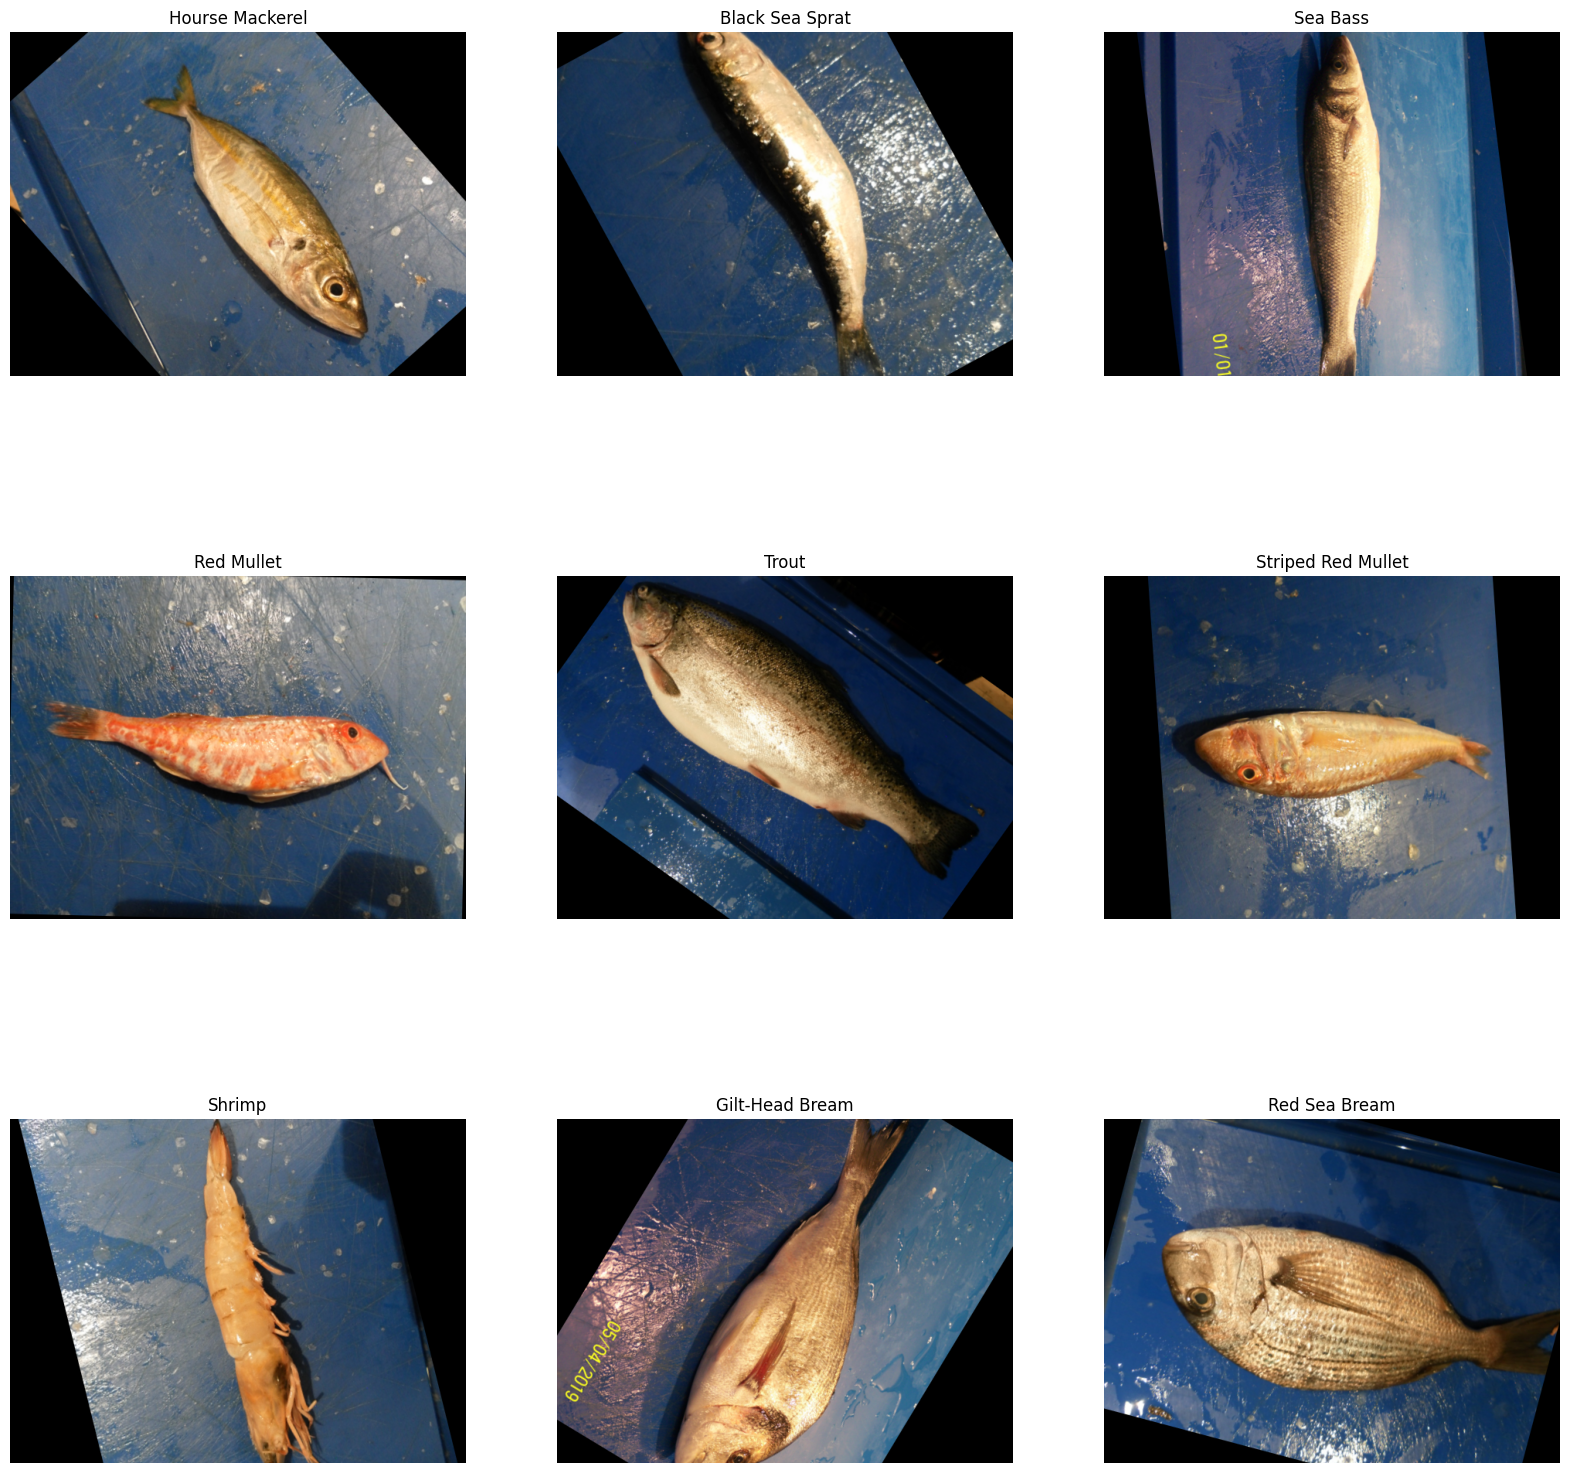

In [123]:
counter = 0
plt.figure(figsize=(20,20))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, counter+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    counter+=1

- **"Red Mullet" etiketine sahip resimlerin ilk 10 tanesini görselleştirme:**

- Dipnot: 10dan fazlaysa ya da 10 taneyse 10 resim döndürür, daha azsa red mulletin 'Red Mullet' uzunluğu kadar resim döndürür--> '**min(10, len(red_mullet_data))**'  

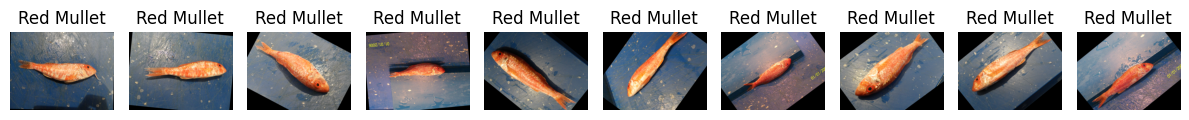

In [124]:
# 'Red Mullet' olanları filtreleme
red_mullet_data = data[data['label'] == 'Red Mullet']

# resim sayısını filtreleme
num_images_to_show = min(10, len(red_mullet_data))  

plt.figure(figsize=(12, 20))

# 'Red Mullet' resimlerini görselleştirme
for i in range(num_images_to_show):
    img_path = red_mullet_data.iloc[i, 0]  # Resim yolunu alma (0. sütun resim yolu)
    
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(plt.imread(img_path))  
    plt.title('Red Mullet')  
    plt.axis('off')  

plt.tight_layout()
plt.show()


- **Veri setindeki etiketlerin (labels) dağılımını pasta grafiği ile gösterme:**

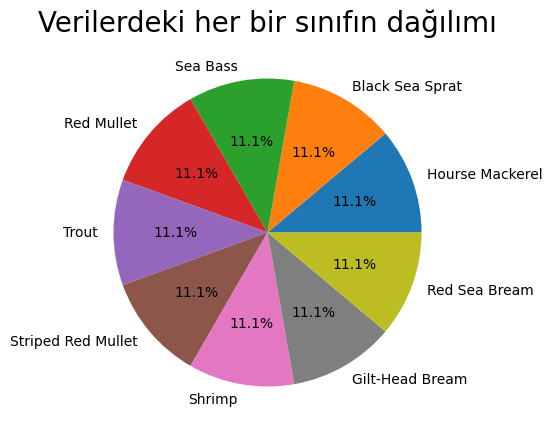

In [125]:
plt.figure(figsize=(10,5))
plt.pie(x=data['label'].value_counts().values,labels=data['label'].value_counts().index,autopct='%1.1f%%')
plt.title('Verilerdeki her bir sınıfın dağılımı',size=20)
plt.show()

- **Belirli bir sabit tohum (seed) ayarlayarak rastgele sayıların üretilmesini kontrol ediyorum..**

In [126]:
# Sabit bir seed belirleme
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


- **Veri setinden görüntü dosyalarını yükleyip eğitim ve test setlerine ayırıyorum..**

In [127]:
# paths ve labels'ı elde etme
paths = data['path'].values # DataFrame'den görüntü dosyası yollarını alma
labels = data['label'].values# DataFrame'den etiketleri alma

# Verileri eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, random_state=42)

# Görüntüleri yüklemek için bir fonksiyon tanımlayalım
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=(28, 28)) # Görüntüyü yükleme ve boyutunu 28x28 piksel yapma
        img_array = tf.keras.preprocessing.image.img_to_array(img)# Yüklenen görüntüyü NumPy dizisine çevirme
        images.append(img_array)
    return np.array(images)

# X_train ve X_test'i görüntü verileri ile doldurma
X_train = load_images(X_train)
X_test = load_images(X_test)



- 28x28 piksel boyutu, performans ve verimlilik açısından birçok derin öğrenme ve görüntü işleme uygulamasında yaygın olarak kullanılmaktadır.

- **Şimdi eğitim ve test setlerindeki görüntü verilerinin (X_train, X_test) ve etiketlerin (y_train, y_test) boyutlarını kontrol edelim..**

In [128]:
# Verilerin boyutlarını kontrol edelim
print('X_train shape:', X_train.shape)  
print('X_test shape:', X_test.shape)    
print('y_train shape:', y_train.shape)                 
print('y_test shape:', y_test.shape)                  

X_train shape: (7200, 28, 28, 3)
X_test shape: (1800, 28, 28, 3)
y_train shape: (7200,)
y_test shape: (1800,)


* 7200: Eğitim setinde toplam 7200 tane görüntü var.
* 28: Her bir görüntünün yüksekliği 28 piksel.
* 28: Her bir görüntünün genişliği 28 piksel.
* 3: Her pikselin 3 renk bileşeni var(Kırmızı, Yeşil, Mavi).

## Veri Ön İşleme

In [129]:
X_train = X_train.reshape(-1, 28, 28, 3).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 3).astype('float32') / 255

- **Görüntü Verilerini Şekillendirme ve Normalizasyon**

Veri setinin derin öğrenme modeline uygun hale getirilmesi için aşağıdaki işlemler yapılır:

1. **Veri Şekillendirme**:
   - `X_train.reshape(-1, 28, 28, 3)` ve `X_test.reshape(-1, 28, 28, 3)` kullanılarak görüntü verileri, her biri 28x28 piksel boyutunda ve 3 renk kanalı (RGB) olan diziler haline getirilir. 
   - `-1` ifadesi, mevcut toplam öğe sayısını koruyarak boyutları ayarlamak için kullanılır.
2. **Veri Tipinin Değiştirilmesi**:
   - `astype('float32')`, verilerin 32 bit kayan nokta (float32) formatına dönüştürülmesini sağlar, bu da modelin verimliliğini artırır.
3. **Normalizasyon**:
   - `/ 255` işlemi, piksel değerlerini 0 ile 1 arasında bir ölçeğe çeker. Bu, modelin daha iyi öğrenmesini sağlar ve eğitim sürecini hızlandırır.

Kısaca bu işlemler, görüntü verilerini uygun bir biçime dönüştürerek derin öğrenme modelinin performansını artırmaya yardımcı olur.


In [130]:
# Verilerin boyutlarını kontrol edelim
print('X_train shape:', X_train.shape)  
print('X_test shape:', X_test.shape)    

X_train shape: (7200, 28, 28, 3)
X_test shape: (1800, 28, 28, 3)


- **Eğitim verilerinin validation (doğrulama) setine ayrılması:**

In [131]:
# Eğitim verilerini validation setine ayırma
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


- *Bu işlem, modelin eğitim sürecinde genel performansını değerlendirmek için kritik bir adımdır ve aşırı uyum (overfitting) riskini azaltmaya yardımcı olur..

- **Sınıf etiketlerini sayısal değerlere dönüştürme:**

In [132]:
# LabelEncoder ile etiketleri sayısal değerlere çevirme
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


- LabelEncoder, kategorik etiketleri sayısal değerlere dönüştürmek için kullanılır. Bizim burada sınıf etiketlerimiz sayısal olmadığı için onları sayısal değerlere çeviriyoruz.

- **Sayısal etiketleri one-hot encoding formatına dönüştürme:**

In [133]:
# One-hot encoding işlemi
y_train = to_categorical(y_train_encoded, num_classes=9)
y_val= to_categorical(y_val_encoded, num_classes=9)
y_test= to_categorical(y_test_encoded, num_classes=9)


- Bu işlem, derin öğrenme modellerinde kategorik etiketlerin işlenmesi için yaygın olarak kullanılan bir yöntemdir. One-hot encoding, sınıflar arasında daha iyi ayrım yapmayı sağlar ve modelin öğrenmesini iyileştirir.
- One-hot encoding, kategorik verileri ikili bir formatta temsil etme yöntemidir. Her bir etiket, belirli bir sınıfa karşılık gelen bir vektörle gösterilir. Örneğin, 3 sınıf için "2" etiketi [0, 1, 0] ile temsil edilir.

- **Eğitim setindeki `y_train` dizisinin ilk üç elemanını gösterme:**

In [134]:
y_train[:3]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.]])

# **MODELLEME**

**Model Oluşturma**


**1. İnput Layer Oluşturma**

In [135]:
# Modeli tanımlayalım
model = tf.keras.models.Sequential()

# Input layer oluşturalım
input_shape = (28, 28, 3)  # RGB görüntü boyutu
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(Flatten())  # Görüntüleri düzleştirme
model.add(tf.keras.layers.Dropout(0.2))



Görüntü verisinin yapısı (28, 28, 3) olduğundan, bu veriyi doğrudan bir Dense katmanına vermek boyut uyumsuzluğuna neden olabileceğinden (Dense katmanı yalnızca 1D (tek boyutlu) verileri kabul eder. Görüntülerim ise RGB formatında renkli görüntüler olduğu için (28, 28, 3) şeklinde 3 boyutlu), modelin giriş katmanında Dense yerine Flatten katmanını kullandım. Bu sayede, görüntü verisini tek boyutlu hale getirerek özniteliklerin daha iyi çıkarılmasını sağladım ve ardından Dense katmanları ile modelin öğrenme kapasitesini artırdım.

**2. Hidden Layer Oluşturma**

In [136]:
# İlk gizli katman
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
# İkinci gizli katman
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))



- Bu gizli katmanlar, modelin daha karmaşık özellikleri öğrenmesini ve genelleme yeteneğini artırmasını sağlar. ReLU aktivasyon fonksiyonu, öğrenme sürecini hızlandırırken, dropout katmanı ise aşırı uyumu önlemek için önemlidir. Bu yapı, derin öğrenme modellerinin etkinliğini artırmak için yaygın olarak kullanılır.
- 256 ve 128 nöron kullanımı, modelin karmaşıklığını artırırken, aynı zamanda aşırı uyum riskini dengelemeye yardımcı olur. İlk katmandaki yüksek nöron sayısı, karmaşık ilişkileri öğrenmesine olanak tanırken, ikinci katmandaki azaltılmış sayı, öğrenilen bilgilerin daha iyi genelleştirilmesini sağlar. Bu denge, derin öğrenme modellerinin etkili ve verimli bir şekilde çalışmasını sağlamak için kritik öneme sahiptir. **Denemelerde 256-128 nöoranla daha iyi sonuçlar elde edilmiştir..**

**3. Output Layer Oluşturma**

In [137]:
# Çıkış katmanını ekleyelim. Bizim labelimiz da 9 sınıfımız var..
model.add(tf.keras.layers.Dense(9, activation='softmax')) 

Çok sınıflı bir sınıflandırma problemi üzerinde çalışıyoruz bu nedenle çıkış katmanındaki aktivasyon fonksiyonu olarak softmax kullandık. (labelimiz 9 sınıf içeriyor.)

**Model Derleme**

In [138]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  
              metrics=['accuracy'])


- Bu aşamada 'categorical_crossentropy' **çok sınıflı sınıflandırma problemlerinde doğru tahminlerin hesaplanmasında kullanıldığı için kullandım. Çünkü 9 sınıfımız var..**
- optimizer='adam' derin öğrenme model derleme aşamasında olduça sık kullanılan bir optimizer'dir. **'adam' dışında 'RMSprop' ve 'SGD' de deneyip 'adam' ile daha başarılı sonuç elde ettim.**
- **Metrics = Accuracy**: Modelin genel başarısını hızlı bir şekilde değerlendirir.

- **Early Stopping:** 

In [139]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik (doğrulama kaybı)
    patience=3,          #  val_loss iyileşmezse 3 epoch sonra durdur
    restore_best_weights=True,  # En iyi modelin ağırlıklarını geri yükle
    verbose=1            # Durum güncellemelerini yazdır
)

- **Early Stopping modelin aşırı öğrenmesini engelleyerek daha iyi bir genelleme yapmasını sağlar ve eğitim sürecini daha verimli hale getirir.**

In [140]:
# Modeli eğitelim
results = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=128, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1929 - loss: 2.1387 - val_accuracy: 0.4035 - val_loss: 1.6275
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4224 - loss: 1.6053 - val_accuracy: 0.5535 - val_loss: 1.3062
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5354 - loss: 1.3052 - val_accuracy: 0.6507 - val_loss: 1.0600
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5959 - loss: 1.1447 - val_accuracy: 0.7069 - val_loss: 0.8784
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6464 - loss: 1.0001 - val_accuracy: 0.7410 - val_loss: 0.7738
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 0.8815 - val_accuracy: 0.7819 - val_loss: 0.6519
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7270 - loss: 0.7881 - val_accuracy: 0.7965 - val_loss: 0.6018
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7523 - loss: 0.7046 - val_accuracy: 0.8229 - val_loss

- Bu işlem sonucunda model, belirtilen epoch sayısı boyunca eğitim verileri üzerinde öğrenir ve doğrulama verileri ile performansını değerlendirir. Early stopping ile modelin en iyi performansı sergilediği ağırlıklar korunur.

### Sonuçların Değerlendirilmesi
- **Eğitim Doğruluğu**: Model, her epoch'ta eğitim setinde doğruluğunu artırmış ve son epoch'ta %79.86 doğruluk oranına ulaşmıştır.
- **Eğitim Kaybı**: Eğitim kaybı, ilk epoch'tan itibaren sürekli azalmış ve son epoch'ta 0.5779'a düşmüştür. Bu, modelin eğitim verileri üzerinde daha iyi bir performans sergilediğini göstermektedir.
- **Doğrulama Doğruluğu**: Doğrulama setindeki doğruluk da sürekli artmış ve %86.46'ya ulaşmıştır. Bu, modelin genel performansının da iyileştiğini gösterir.
- **Doğrulama Kaybı**: Doğrulama kaybı da her epoch'ta düşerek son epoch'ta 0.4360'a ulaşmıştır. Bu durum, modelin hem eğitim hem de doğrulama setlerinde iyi bir öğrenme sağladığını gösterir.

### Erken Durdurma
Eğitim süreci, en iyi doğrulama kaybı değerini elde etmek için `EarlyStopping` callback'i ile durdurulmuştur. Bu, aşırı öğrenmeyi (overfitting) önlemek amacıyla modelin en iyi durumdaki ağırlıklarını geri yüklemesine olanak tanımıştır.

Sonuç olarak, model iyi bir öğrenme süreci geçirmiştir ve elde edilen doğruluk değerleri, modelin performansının memnuniyet verici olduğunu göstermektedir.

- **Eğitim Sonuçlarının Görselleştirilmesi:**

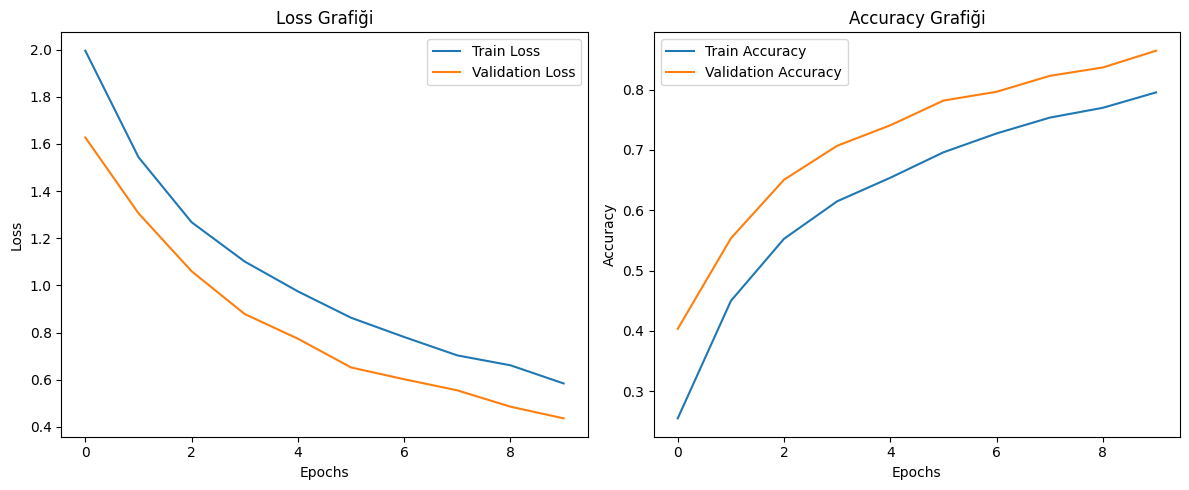

In [141]:
# Eğitim sonuçlarını görselleştirelim
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

- Yukarıdaki sonuçlar, eğitim sürecindeki kayıp (loss) ve doğruluk (accuracy) değerlerini görsel olarak sunan grafiklerle de desteklenmiştir. Bu grafikler, modelin eğitim ve doğrulama aşamalarındaki performansını daha iyi anlamamıza yardımcı olmaktadır.

- **Test Seti ile Tahmin Yapma**

In [142]:
# Test seti ile tahmin yapalım
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


- **Modelin test setindeki ilk 20 örnek için tahmin ettiği sınıf etiketlerini döndürme:**

In [143]:
y_pred_classes[:20]

array([1, 0, 2, 0, 4, 4, 7, 4, 3, 4, 5, 0, 3, 6, 7, 3, 1, 4, 4, 3])

- **Test seti üzerinde modeli değerlendirme:**

In [144]:
# Test seti üzerinde modeli değerlendirelim
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.43541812896728516
Test Accuracy: 0.879444420337677


- **Test Loss (0.4354): Bu değer, modelin test seti üzerindeki kaybını (hata miktarını) gösterir. Düşük bir kayıp, modelin test verileri üzerinde iyi bir genel performans sergilediğini gösterir.**

- **Test Accuracy (0.8794): Bu oran, modelin test setindeki doğru tahminlerinin, toplam tahminlere oranını belirtir. %87.94'lük bir doğruluk, modelin test setindeki sınıflandırma görevinde oldukça başarılı olduğunu göstermektedir.**

Sonuç olarak, modelin test verileri üzerinde genel olarak iyi bir performans sergilediği söylenebilir. 

- **Modelin test seti üzerindeki performansını değerlendirme ve sonuçları görselleştirme:**

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


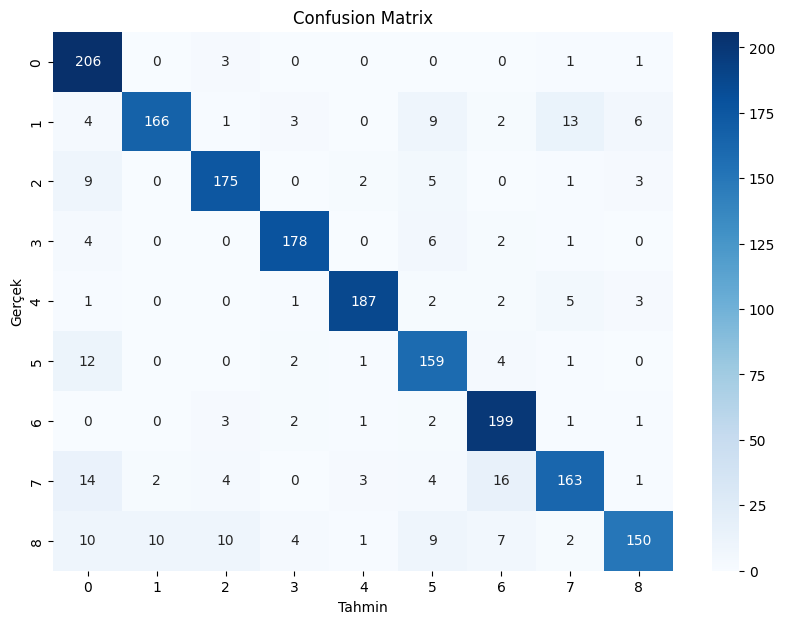

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       211
           1       0.93      0.81      0.87       204
           2       0.89      0.90      0.90       195
           3       0.94      0.93      0.93       191
           4       0.96      0.93      0.94       201
           5       0.81      0.89      0.85       179
           6       0.86      0.95      0.90       209
           7       0.87      0.79      0.83       207
           8       0.91      0.74      0.82       203

    accuracy                           0.88      1800
   macro avg       0.88      0.88      0.88      1800
weighted avg       0.88      0.88      0.88      1800



In [145]:
# Test seti ile tahmin yapalım
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketleri ve tahmin edilen etiketleri elde edelim
y_true = np.argmax(y_test, axis=1)

# Confusion matrix'i oluşturalım
cm = confusion_matrix(y_true, y_pred_classes)

# Confusion matrix'i görselleştirelim
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()

# Classification report'u yazdıralım
print(classification_report(y_true, y_pred_classes))


 **Genel Performans**
- Doğruluk (Accuracy): 0.88, modelin genel başarısını gösterir.
- Makro Ortalama: Tüm sınıfların ortalamalarını alır ve sınıflar arasında dengeyi gösterir; 0.88.
- Ağırlıklı Ortalama: Sınıf desteklerine göre ağırlıklandırılmış ortalamadır, yine 0.88.

 **Sonuçlar**

Model genel olarak iyi bir performansa sahip. Ancak, bazı sınıflarda (özellikle sınıf 5 ve 7) duyarlılığı artırmak için iyileştirmeler yapılabilir. Bu, modelin yanlış negatif tahminlerini azaltarak daha dengeli bir performans elde etmeye yardımcı olabilir.

# Model Performansı ve Sonuçlar (Hiperparametre Optimizasyonu Bazı Örnekler:)

## DENSE(64-32)

- **Test Loss:** 1.15
- **Test Accuracy:** 0.63

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|--------|
| 0     | 0.61      | 0.92   | 0.73     | 211    |
| 1     | 0.54      | 0.57   | 0.56     | 204    |
| 2     | 0.60      | 0.76   | 0.67     | 195    |
| 3     | 0.68      | 0.84   | 0.75     | 191    |
| 4     | 0.87      | 0.61   | 0.72     | 201    |
| 5     | 0.49      | 0.34   | 0.40     | 179    |
| 6     | 0.67      | 0.82   | 0.73     | 209    |
| 7     | 0.70      | 0.32   | 0.44     | 207    |
| 8     | 0.61      | 0.49   | 0.54     | 203    |

- **Accuracy:** 0.63
- **Macro Average:** Precision: 0.64, Recall: 0.63, F1-Score: 0.62
- **Weighted Average:** Precision: 0.64, Recall: 0.63, F1-Score: 0.62

---

## DENSE(128-64)

- **Test Loss:** 0.89
- **Test Accuracy:** 0.71

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|--------|
| 0     | 0.67      | 0.99   | 0.80     | 211    |
| 1     | 0.89      | 0.36   | 0.51     | 204    |
| 2     | 0.71      | 0.79   | 0.75     | 195    |
| 3     | 0.72      | 0.90   | 0.80     | 191    |
| 4     | 0.79      | 0.82   | 0.80     | 201    |
| 5     | 0.70      | 0.56   | 0.62     | 179    |
| 6     | 0.71      | 0.85   | 0.77     | 209    |
| 7     | 0.75      | 0.47   | 0.58     | 207    |
| 8     | 0.62      | 0.69   | 0.65     | 203    |

- **Accuracy:** 0.71
- **Macro Average:** Precision: 0.73, Recall: 0.71, F1-Score: 0.70
- **Weighted Average:** Precision: 0.73, Recall: 0.71, F1-Score: 0.70

---

## Dropout: 0.4

- **Test Loss:** 0.900547981262207
- **Test Accuracy:** 0.7361111044883728


| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|--------|
| 0     | 0.78      | 0.91   | 0.84     | 211    |
| 1     | 0.79      | 0.62   | 0.70     | 204    |
| 2     | 0.85      | 0.71   | 0.77     | 195    |
| 3     | 0.72      | 0.90   | 0.80     | 191    |
| 4     | 0.67      | 0.94   | 0.78     | 201    |
| 5     | 0.69      | 0.72   | 0.70     | 179    |
| 6     | 0.68      | 0.87   | 0.76     | 209    |
| 7     | 0.74      | 0.35   | 0.47     | 207    |
| 8     | 0.77      | 0.64   | 0.70     | 203    |

- **Accuracy:** 0.74
- **Macro Average:** Precision: 0.74, Recall: 0.74, F1-Score: 0.72
- **Weighted Average:** Precision: 0.74, Recall: 0.74, F1-Score: 0.72

---

## Dropout: 0.2 | Dense (256,128) | Gizli Katman Sayısı: 2 | Optimizer: Adam

- **Test Loss:** 0.44
- **Test Accuracy:** 0.88

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|--------|
| 0     | 0.79      | 0.98   | 0.87     | 211    |
| 1     | 0.93      | 0.81   | 0.87     | 204    |
| 2     | 0.89      | 0.90   | 0.90     | 195    |
| 3     | 0.94      | 0.93   | 0.93     | 191    |
| 4     | 0.96      | 0.93   | 0.94     | 201    |
| 5     | 0.81      | 0.89   | 0.85     | 179    |
| 6     | 0.86      | 0.95   | 0.90     | 209    |
| 7     | 0.87      | 0.79   | 0.83     | 207    |
| 8     | 0.91      | 0.74   | 0.82     | 203    |

- **Accuracy:** 0.88
- **Macro Average:** Precision: 0.88, Recall: 0.88, F1-Score: 0.88
- **Weighted Average:** Precision: 0.88, Recall: 0.88, F1-Score: 0.88

---

## 3 Gizli Katman

- **Test Loss:** 0.57
- **Test Accuracy:** 0.81

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|--------|
| 0     | 0.75      | 0.98   | 0.85     | 211    |
| 1     | 0.87      | 0.68   | 0.76     | 204    |
| 2     | 0.91      | 0.84   | 0.87     | 195    |
| 3     | 0.94      | 0.84   | 0.89     | 191    |
| 4     | 0.84      | 0.92   | 0.88     | 201    |
| 5     | 0.68      | 0.89   | 0.77     | 179    |
| 6     | 0.74      | 0.96   | 0.84     | 209    |
| 7     | 0.86      | 0.54   | 0.66     | 207    |
| 8     | 0.87      | 0.69   | 0.77     | 203    |

- **Accuracy:** 0.81
- **Macro Average:** Precision: 0.83, Recall: 0.81, F1-Score: 0.81
- **Weighted Average:** Precision: 0.83, Recall: 0.81, F1-Score: 0.81

---

## 4 Gizli katman  
- **Test Loss:** 0.7500270009040833
- **Test Accuracy:** 0.7716666460037231

---

## Optimizer: SGD

- **Test Loss:** 1.624692440032959
- **Test Accuracy:** 0.5038889050483704


| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|--------|
| 0     | 0.67      | 0.90   | 0.77     | 211    |
| 1     | 0.75      | 0.55   | 0.64     | 204    |
| 2     | 0.73      | 0.79   | 0.76     | 195    |
| 3     | 0.66      | 0.84   | 0.74     | 191    |
| 4     | 0.88      | 0.62   | 0.73     | 201    |
| 5     | 0.67      | 0.58   | 0.62     | 179    |
| 6     | 0.71      | 0.76   | 0.73     | 209    |
| 7     | 0.60      | 0.29   | 0.39     | 207    |
| 8     | 0.70      | 0.54   | 0.61     | 203    |

- **Accuracy:** 0.71
- **Macro Average:** Precision: 0.72, Recall: 0.71, F1-Score: 0.70
- **Weighted Average:** Precision: 0.71, Recall: 0.71, F1-Score: 0.70

---

## Optimizer: RMSprop

- **Test Loss:** 0.7880235314369202
- **Test Accuracy:** 0.7400000095367432

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|--------|
| 0     | 0.71      | 0.90   | 0.79     | 211    |
| 1     | 0.69      | 0.72   | 0.70     | 204    |
| 2     | 0.74      | 0.75   | 0.75     | 195    |
| 3     | 0.74      | 0.88   | 0.81     | 191    |
| 4     | 0.94      | 0.72   | 0.81     | 201    |
| 5     | 0.63      | 0.87   | 0.73     | 179    |
| 6     | 0.74      | 0.90   | 0.81     | 209    |
| 7     | 0.88      | 0.36   | 0.52     | 207    |
| 8     | 0.84      | 0.63   | 0.72     | 203    |

- **Accuracy:** 0.76
- **Macro Average:** Precision: 0.76, Recall: 0.76, F1-Score: 0.75
- **Weighted Average:** Precision: 0.76, Recall: 0.76, F1-Score: 0.75


---



## Açıklamalar

1. **Dropout: 0.2**
   - **Neden Seçildi?**: Aşırı öğrenmeyi önlemek için %20'lik bir dropout oranı, modelin genelleyici yeteneğini artırır.

2. **Gizli Katman Sayısı: 2**
   - **Neden Seçildi?**: İki gizli katman, modelin karmaşık ilişkileri öğrenme kapasitesini artırırken, aşırı öğrenme riskini azaltır.

3. **Optimizer: Adam**
   - **Neden Seçildi?**: Adam, adaptif öğrenme oranları kullanarak daha hızlı ve verimli bir öğrenme sağlar. Özellikle büyük veri setlerinde etkilidir.

5. **Dense: 256, 128**
   - **Neden Seçildi?**: Bu yoğun katmanlar, modelin daha fazla özellik öğrenme kapasitesini artırarak genel performansı iyileştirir.
   
  ## Sonuç 
- **Optimizer: Adam, 2 Gizli Katman, Dense: 256, 128 ve Dropout: 0.2 uygulamasıyla birlikte, yüksek performans gösteren dengeli bir model oluşturur. Bu yapılandırma diğer parametrelerle elde edilen modellere göre, genel olarak başarılı sınıflandırma sonuçları ve sağlam bir öğrenme süreci sağlar. Hem doğruluk hem de kayıp açısından tatmin edici sonuçlar elde edilmesi, bu yapılandırmanın pek çok uygulamada kullanılabilir olduğunu gösteriyor.**


## Model Performansı ve Aşırı Öğrenme (Overfitting) Analizi

- **Eğitim, Doğrulama ve Test Sonuçları**

**Eğitim Sonuçları (Epoch 10):**
- **Eğitim Doğruluğu:** %79.86
- **Eğitim Kaybı:** 0.5779

**Doğrulama Sonuçları (Epoch 10):**
- **Doğrulama Doğruluğu:** %86.46
- **Doğrulama Kaybı:** 0.4360

**Test Sonuçları:**
- **Test Doğruluğu:** %87.94
- **Test Kaybı:** 0.4354

- **Aşırı Öğrenme Durumunun Değerlendirilmesi**

Aşırı öğrenmenin (overfitting) olup olmadığını belirlemek için, modelin eğitim, doğrulama ve test setlerindeki performansını analiz etmek önemlidir. İşte bu analizin sonuçları:

1. **Eğitim ve Doğrulama Doğruluğu:**
   - Eğitim doğruluğu (%79.86) ve doğrulama doğruluğu (%86.46) arasındaki fark oldukça makuldür (yaklaşık %6.6). Aşırı öğrenme durumunda, eğitim doğruluğu çok yüksek (örneğin %95 üzeri) olurken, doğrulama doğruluğu daha düşük (örneğin %70'ler) kalır. Burada ise doğrulama doğruluğunun eğitim doğruluğuna yakın olması, modelin eğitildiği verilerden iyi bir şekilde genelleme yaptığını gösterir.

2. **Eğitim ve Doğrulama Kayıpları:**
   - Eğitim kaybı (0.5779) ve doğrulama kaybı (0.4360) arasındaki fark da küçüktür. Aşırı öğrenme durumunda genellikle eğitim kaybı düşerken, doğrulama kaybı artar. Burada her iki kayıp da oldukça yakın ve kabul edilebilir bir seviyede. Bu, modelin aşırı öğrenmeden kaçındığını ve öğrendiklerini yeni verilere uygulamakta başarılı olduğunu gösterir.

3. **Test Performansı:**
   - Test setindeki doğruluk (%87.94) ve kayıp (0.4354), eğitim ve doğrulama sonuçlarıyla uyum içerisindedir. Test setindeki yüksek doğruluk, modelin eğitim sürecinde öğrendiği bilgileri daha önce görmediği veriler üzerinde de iyi bir şekilde genelleyebildiğini gösterir. Aşırı öğrenme durumunda, test doğruluğu genellikle düşer.

## Sonuç ve Değerlendirme

Modelin eğitim, doğrulama ve test sonuçları birbirine yakındır ve tutarlıdır. Bu durum, modelin hem eğitim verilerine hem de yeni verilere karşı iyi bir performans sergilediğini, dolayısıyla aşırı öğrenme riski taşımadığını göstermektedir.

- **Sonuç olarak, modelin aşırı öğrenme yapmadığı, eğitim sürecinde dengeli bir şekilde öğrenme gerçekleştirdiği ve gerçek dünya verilerine uygulanabilir bir performans sergilediği açıktır. Bu, modelin pratik uygulamalar için güvenilir bir seçenek olduğunu gösterir.**
